

# PEC2: Insights datos Idealista

En esta PEC2, debéis hacer el mismo ejercicio que hemos hecho en el Notebook Insight_Datos_Teleco.ipynb pero con la información de Idealista que se os proporciona junto a este Notebook y el enunciado. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.



## Cargar librerías

In [2]:
%matplotlib inline

import re
import random
from collections import Counter

import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
sns.set(color_codes=True)




## 1. Lectura y unificación de datos. Puede ser tanto de la descarga de Idealista si hiciesteis la PEC1 versión con Claves, o directamente los 8 ficheros CSV. (2 puntos)

In [3]:
n = 8
dfs = []

for i in range(1, n+1):
    file_name = f"data/BBDD_{i}.csv"
    df = pd.read_csv(file_name)
    dfs.append(df)
   
dataset = pd.concat(dfs, ignore_index=True)

dataset.to_csv('dsanchezcorb_BBDD.csv', encoding='utf-8', index=False)

df = pd.read_csv('dsanchezcorb_BBDD.csv')

C:\Users\Usuario\AppData\Local\Temp\ipykernel_6396\735219059.py:13: DtypeWarning: Columns (23,29,35,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dsanchezcorb_BBDD.csv')


### Comprobar lectura correcta del dataset

In [4]:
df.head()


,Unnamed: 0.1,Unnamed: 0,index,propertyCode,thumbnail,externalReference,numPhotos,floor,price,propertyType,...,suggestedTexts,hasPlan,has3DTour,has360,hasStaging,superTopHighlight,topNewDevelopment,labels,parkingSpace,newDevelopmentFinished
0,0.0,0.0,0.0,37423711,https://img3.idealista.com/blur/WEB_LISTING/0/id.pro.es.image.master/75/65/7d/1051146532.jpg,Z-2030,31.0,2,285000.0,flat,...,"{'subtitle': 'El Gòtic, Barcelona', 'title': 'Piso'}",True,False,False,False,False,False,NaN,NaN,NaN
1,1.0,1.0,1.0,100030792,https://img3.idealista.com/blur/WEB_LISTING/0/id.pro.es.image.master/08/c0/ea/1065800123.jpg,2019,54.0,NaN,178216.0,flat,...,"{'subtitle': 'El Guinardó, Barcelona', 'title': 'Piso en Calle del Xiprer'}",False,False,False,False,False,False,NaN,NaN,NaN
2,2.0,2.0,2.0,95563945,https://img3.idealista.com/blur/WEB_LISTING/0/id.pro.es.image.master/cf/05/33/921983717.jpg,52931158,13.0,NaN,333000.0,flat,...,"{'subtitle': 'El Gòtic, Barcelona', 'title': 'Piso en Calle dels Còdols'}",False,False,True,False,False,False,NaN,NaN,NaN
3,3.0,3.0,3.0,96266051,https://img3.idealista.com/blur/WEB_LISTING/0/id.pro.es.image.master/dd/0e/ff/942136095.jpg,4113 ALIV,27.0,2,481000.0,flat,...,"{'subtitle': ""La Dreta de l'Eixample, Barcelona"", 'title': 'Piso en Rambla de Catalunya'}",False,False,False,False,False,False,NaN,NaN,NaN
4,4.0,4.0,4.0,95845899,https://img3.idealista.com/blur/WEB_LISTING/0/id.pro.es.image.master/17/29/61/930553000.jpg,52457390,10.0,NaN,481000.0,flat,...,"{'subtitle': ""La Dreta de l'Eixample, Barcelona"", 'title': 'Piso en Rambla de Catalunya'}",False,False,True,False,False,False,NaN,NaN,NaN


### Comprobar dimensiones del dataset

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21186 entries, 0 to 21185
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0.1            5614 non-null   float64
 1   Unnamed: 0              17806 non-null  float64
 2   index                   12962 non-null  float64
 3   propertyCode            21186 non-null  int64  
 4   thumbnail               21067 non-null  object 
 5   externalReference       18796 non-null  object 
 6   numPhotos               21186 non-null  float64
 7   floor                   15890 non-null  object 
 8   price                   21186 non-null  float64
 9   propertyType            21186 non-null  object 
 10  operation               21186 non-null  object 
 11  size                    21186 non-null  float64
 12  exterior                21186 non-null  bool   
 13  rooms                   21186 non-null  float64
 14  bathrooms               21186 non-null

In [6]:
# Llegados a este punto antes de proceder al formateo de variables, decido eliminar algunos campos que no nos van a dar ningún tipo de información interesante en este estudio.
# Como en este caso los dos 'unnamed' y 'index', así como 'detailedType', 'suggestedTexts' y 'labels', estos últimos por contener información repetida de otros campos.
# De la misma forma eliminaré 'description' porque solo incluye información subjetiva y no cuantificable, como 'thumbnail' por carecer de valor.
# Por último descarto los campos 'address', 'district' y 'neighborhood', que podrían ser interesantes si filtrasemos el dataframe por municipios o provincias, pero haciendolo de toda España considero que solo nos aporta ruido al estudio.

df = df.drop(['Unnamed: 0.1', 'Unnamed: 0', 'index', 'detailedType', 'suggestedTexts', 'labels', 'description', 'thumbnail', 'address', 'district', 'neighborhood'], axis = 1)


In [7]:
# Mención aparte merece la columna 'operation':

df.operation.value_counts()


sale    21118
rent       68
Name: operation, dtype: int64

In [8]:
# como podemos observar el número de pisos de alquiler es insignificante con respecto al número de pisos en venta y nos crea discrepancias en campos como 'precio' y 'precio por area'
# la fórmula mas lógica me ha parecido que sería separarlo en 2 dataframes diferentes pero puesto que las entradas de alquiler son tan reducidas, me he decantado por filtrar solo los pisos de venta

df = df.loc[df['operation'] == 'sale']

print(df.operation.value_counts())

# y a continuación eliminamos esa columna y mostrar el resultado final.

df = df.drop(['operation'], axis = 1)

df.info()


sale    21118
Name: operation, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21118 entries, 0 to 21185
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   propertyCode            21118 non-null  int64  
 1   externalReference       18796 non-null  object 
 2   numPhotos               21118 non-null  float64
 3   floor                   15825 non-null  object 
 4   price                   21118 non-null  float64
 5   propertyType            21118 non-null  object 
 6   size                    21118 non-null  float64
 7   exterior                21118 non-null  bool   
 8   rooms                   21118 non-null  float64
 9   bathrooms               21118 non-null  float64
 10  province                21118 non-null  object 
 11  municipality            21118 non-null  object 
 12  country                 21118 non-null  object 
 13  latitude                21118 non-null  float64

## 2. Data Wrangling (4 puntos)



### Formateo de las variables (strings, numéricas y booleanas)

In [9]:
#creamos un diccionario con el tipo de variables que corresponderá a las columnas

Format = ['str', 'str', 'int', 'str', 'int', 'str', 'int', 'bool', 'int', 'int',
         'str', 'str', 'str', 'float', 'float', 'bool', 'str', 'int', 'bool', 'str', 'bool',
         'bool', 'float', 'bool', 'bool','bool', 'bool', 'bool', 'bool', 'bool', 'bool']
dict_format = dict(zip(df.columns,Format))

In [10]:
# me ha parecido más preciso poner ciertas variables como booleanas, pero antes de hacer la conversión hago un pequeño chequeo de cada una de ellas para asegurarme que solo toman como valor 'True' o 'False'

print(df.exterior.value_counts())
print(df.showAddress.value_counts())
print(df.hasVideo.value_counts())
print(df.newDevelopment.value_counts())
print(df.hasLift.value_counts())
print(df.hasPlan.value_counts())
print(df.has3DTour.value_counts())
print(df.has360.value_counts())
print(df.hasStaging.value_counts())
print(df.superTopHighlight.value_counts())
print(df.topNewDevelopment.value_counts())
print(df.parkingSpace.value_counts())
print(df.newDevelopmentFinished.value_counts())

True     14010
False     7108
Name: exterior, dtype: int64
False    17899
True      3219
Name: showAddress, dtype: int64
False    14538
True      6580
Name: hasVideo, dtype: int64
False    20721
True       397
Name: newDevelopment, dtype: int64
True     12998
False     3607
Name: hasLift, dtype: int64
False    12523
True      8595
Name: hasPlan, dtype: int64
False    20277
True       841
Name: has3DTour, dtype: int64
False    18440
True      2678
Name: has360, dtype: int64
False    20950
True       168
Name: hasStaging, dtype: int64
False    21118
Name: superTopHighlight, dtype: int64
False    21118
Name: topNewDevelopment, dtype: int64
{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': True}                                   5154
{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 20000.0}     119
{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 25000.0}      57
{'hasParkingSpace': True, 'isParkingSpaceIn

In [11]:
# a partir de estos resultados el primer problema que nos encontramos es en la variable 'hasLift' pero arreglarlo doy como premisa que los nulos pertenecen 'False'

df['hasLift'] = df['hasLift'].replace([False, None], False)

print(df.hasLift.value_counts())

# y exactamente igual con la variable 'newDevelopmentFinished'

df['newDevelopmentFinished'] = df['newDevelopmentFinished'].replace([False, None], False)

print(df.newDevelopmentFinished.value_counts())


True     12998
False     8120
Name: hasLift, dtype: int64
False    21086
True        32
Name: newDevelopmentFinished, dtype: int64


In [12]:
# En el caso de 'parkingSpace' lo que he decidido es aceptar como 'True' todos aquellos registros que incorporen ''isParkingSpaceIncludedInPrice': True'
# todos los demas casos, tanto los nulos como los que no incluyen el precio del parking en la vivienda los considero como 'False'

df['parkingSpace'] = df['parkingSpace'].str.contains("'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': True").fillna(False)

print(df.parkingSpace.value_counts())


False    15964
True      5154
Name: parkingSpace, dtype: int64


In [13]:
# antes de proceder con el formateo voy a revisar la variable 'status' que posteriormente utilizaré para el estudio de variables categoricas.

print(df.status.value_counts())
print(df['status'].isnull().sum())

good              17719
renew              3001
newdevelopment      396
Name: status, dtype: int64
2


In [14]:
# elimino los registros sin valor y comprobamos que ya no queda ninguno

df = df.loc[df['status'].isin(['good', 'renew', 'newdevelopment'])]
print(df['status'].value_counts())

df.info()

good              17719
renew              3001
newdevelopment      396
Name: status, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21116 entries, 0 to 21185
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   propertyCode            21116 non-null  int64  
 1   externalReference       18794 non-null  object 
 2   numPhotos               21116 non-null  float64
 3   floor                   15824 non-null  object 
 4   price                   21116 non-null  float64
 5   propertyType            21116 non-null  object 
 6   size                    21116 non-null  float64
 7   exterior                21116 non-null  bool   
 8   rooms                   21116 non-null  float64
 9   bathrooms               21116 non-null  float64
 10  province                21116 non-null  object 
 11  municipality            21116 non-null  object 
 12  country                 21116 non-null  objec

In [15]:
# damos formato

df = df.astype(dict_format)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21116 entries, 0 to 21185
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   propertyCode            21116 non-null  object 
 1   externalReference       21116 non-null  object 
 2   numPhotos               21116 non-null  int32  
 3   floor                   21116 non-null  object 
 4   price                   21116 non-null  int32  
 5   propertyType            21116 non-null  object 
 6   size                    21116 non-null  int32  
 7   exterior                21116 non-null  bool   
 8   rooms                   21116 non-null  int32  
 9   bathrooms               21116 non-null  int32  
 10  province                21116 non-null  object 
 11  municipality            21116 non-null  object 
 12  country                 21116 non-null  object 
 13  latitude                21116 non-null  float64
 14  longitude               21116 non-null



### Comprobación y eliminación de registros repetidos

In [17]:
# Hemos llegado hasta aquí con 3 variables factibles para eliminar registros repetidos: 'propertyCode', 'externalReference' y 'url', 
# En primer lugar empezaré por la variable 'propertyCode' que entiendo es el código de cada una de las viviendas anunciadas.

duplicados=df.duplicated ('propertyCode')
duplicados.value_counts()

False    13021
True      8095
dtype: int64

In [18]:
# los eliminamos y comprobamos que no queda ningún duplicado
df.drop_duplicates(subset=['propertyCode'], keep='last', inplace=True)

duplicados = df.duplicated ('propertyCode')
duplicados.value_counts()


False    13021
dtype: int64

In [19]:
# la variable 'externalReference' también pudiera parecer buena para la eliminación de duplicados.
# Pero al tratarse de una variable externa a la página web, no hay unificación de criterios e incluso algunos han optado por no rellenarla.
# Al no encontrar una solución factible me decanto por descartar esta variable por su falta de rigurosidad.
#
# Dejo comentado el código que hice para estudiar esta variable para la busqueda de posibles duplicados pero no me convenció.
#
# duplicados = df.loc[df['externalReference'] != 'nan']
# duplicados = duplicados.loc[duplicados.duplicated('externalReference', keep=False)]
# print(duplicados.loc[:, 'externalReference'])


In [20]:
# a continuación hago una segunda busqueda de posibles duplicados en la variable 'url', para encontrar posibles discrepancias
# viendo que no existe ninguno, doy por finalizada esta parte

duplicados = df.duplicated ('url')
duplicados.value_counts()

False    13021
dtype: int64



### Comprobación de columnas que no aportan información

In [21]:
# un claro ejemplo de columna que no aporta información es 'country' puesto que todas las busquedas son del mismo pais

print(df.country.value_counts())

# el caso opuesto podría ser 'municipality', como ya adelantamos con 'address', 'district' y 'neighborhood' comprobaremos que el número de categorías no son factibles para un estudio global

print(df.municipality.value_counts())

es    13021
Name: country, dtype: int64
Barcelona                3854
Madrid                    812
Salou                     669
Zaragoza                  643
Reus                      490
                         ... 
Alt Aneu                    1
Zorita del Maestrazgo       1
Aladrén                     1
Berge                       1
Villanueva de Gallego       1
Name: municipality, Length: 380, dtype: int64


In [22]:
# otro ejemplo sería como hemos visto en el apartado anterior 'externalReference' y 'url', esta última por ser tratarse de un identificador que hace la misma función que 'propertyCode'
# procedemos a eliminar pues 'country', 'externalReference' y 'url', y a continuación comprobamos que ha funcionado.
# asi como propertyCode pues ya ha cumplido su función

df = df.drop(['propertyCode', 'country', 'municipality', 'externalReference', 'url'], axis = 1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13021 entries, 299 to 21185
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   numPhotos               13021 non-null  int32  
 1   floor                   13021 non-null  object 
 2   price                   13021 non-null  int32  
 3   propertyType            13021 non-null  object 
 4   size                    13021 non-null  int32  
 5   exterior                13021 non-null  bool   
 6   rooms                   13021 non-null  int32  
 7   bathrooms               13021 non-null  int32  
 8   province                13021 non-null  object 
 9   latitude                13021 non-null  float64
 10  longitude               13021 non-null  float64
 11  showAddress             13021 non-null  bool   
 12  distance                13021 non-null  int32  
 13  hasVideo                13021 non-null  bool   
 14  status                  13021 non-nu



### Estudio de la varianza para las variables numéricas

In [23]:
df_numerical = df.select_dtypes(include = ['int','float'])
print(df_numerical.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13021 entries, 299 to 21185
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   numPhotos    13021 non-null  int32  
 1   price        13021 non-null  int32  
 2   size         13021 non-null  int32  
 3   rooms        13021 non-null  int32  
 4   bathrooms    13021 non-null  int32  
 5   latitude     13021 non-null  float64
 6   longitude    13021 non-null  float64
 7   distance     13021 non-null  int32  
 8   priceByArea  13021 non-null  float64
dtypes: float64(3), int32(6)
memory usage: 712.1 KB
None


In [24]:
variance = df_numerical.var(axis=0)
threshold = 0.02
if all(elemento > threshold for elemento in variance):
    print("Todas las varianzas son superiores a 0.02")

Todas las varianzas son superiores a 0.02




### Estudio de agrupaciones para las variables categóricas

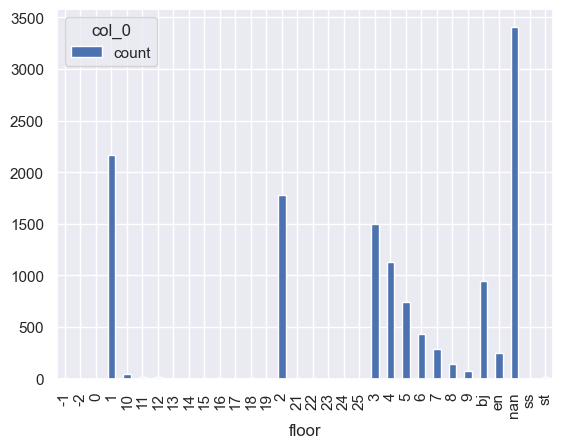

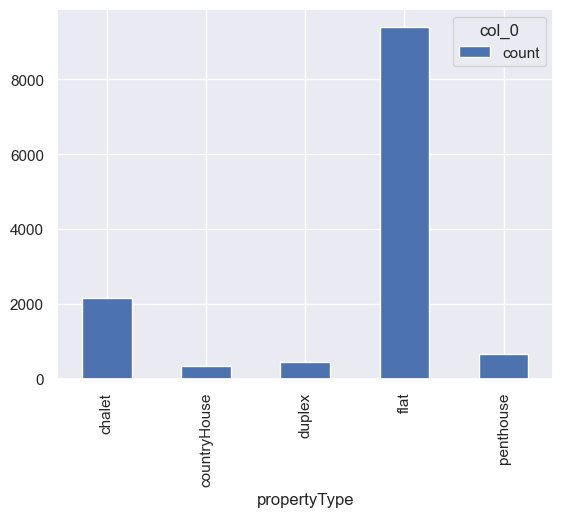

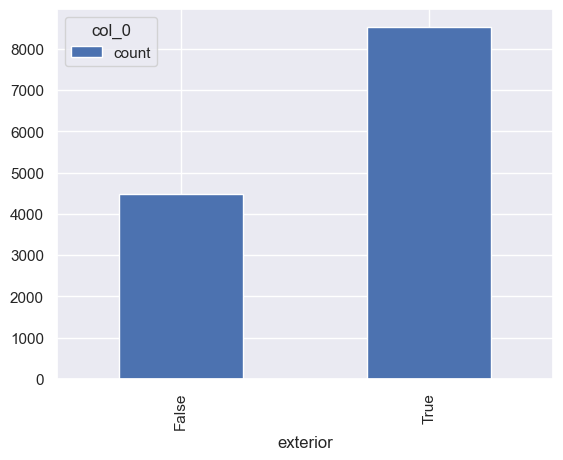

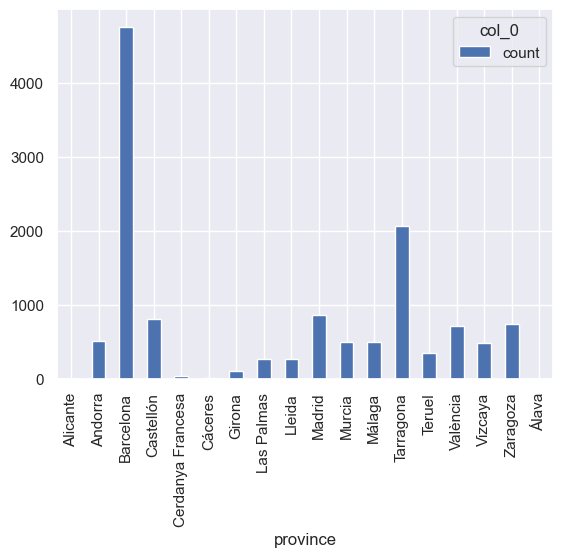

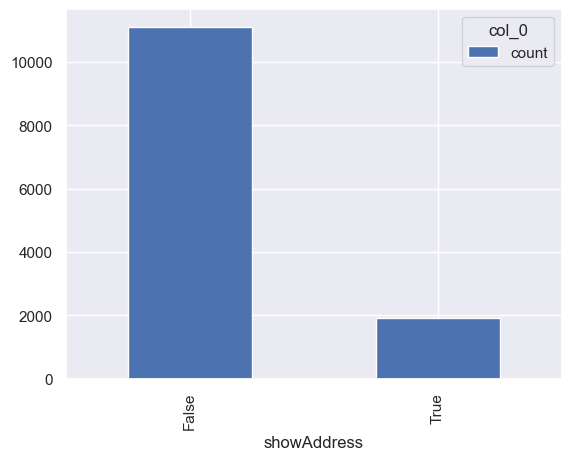

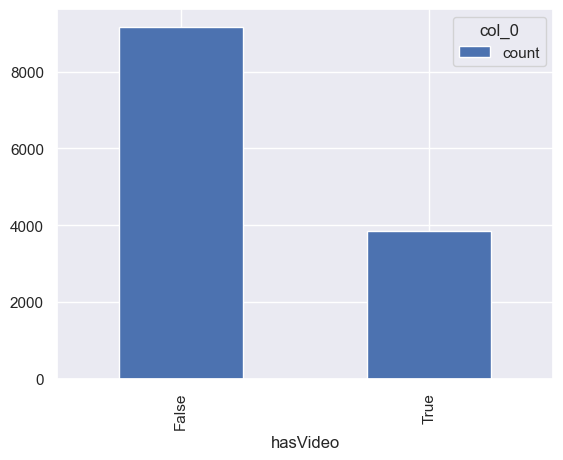

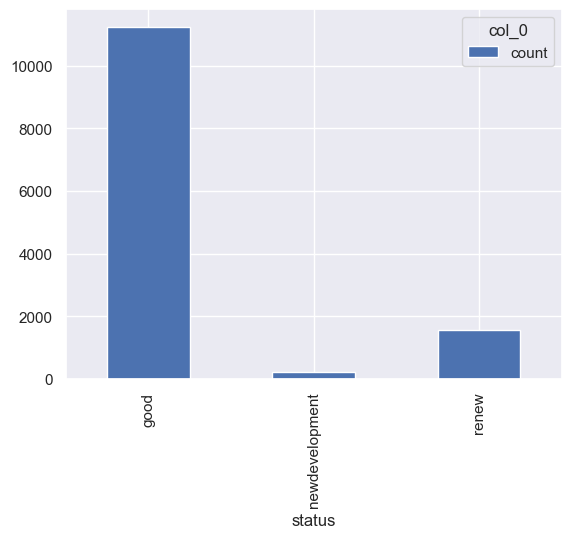

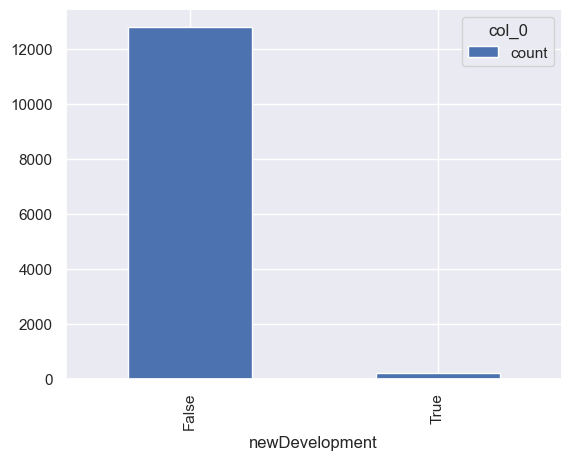

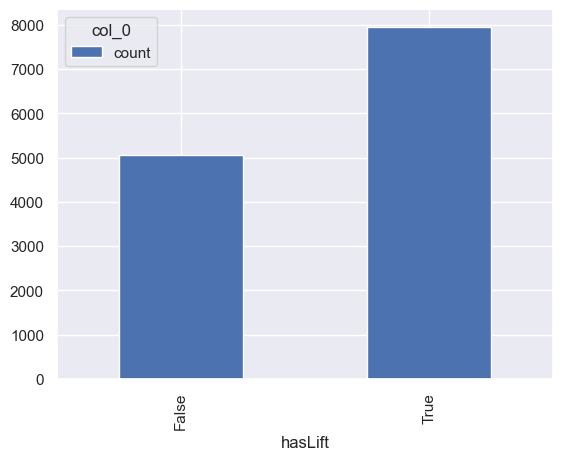

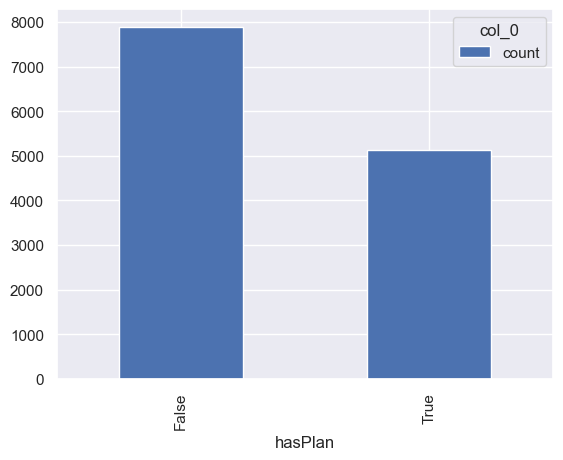

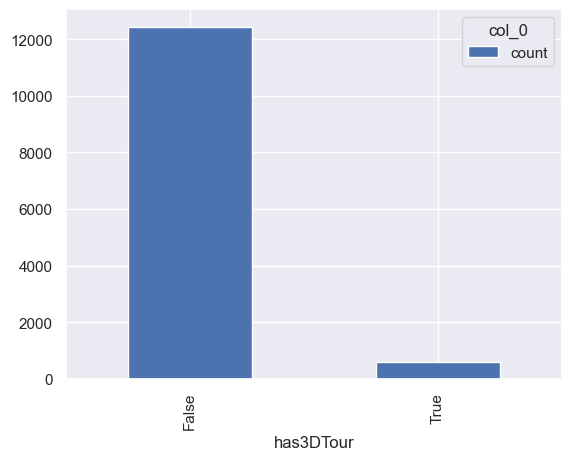

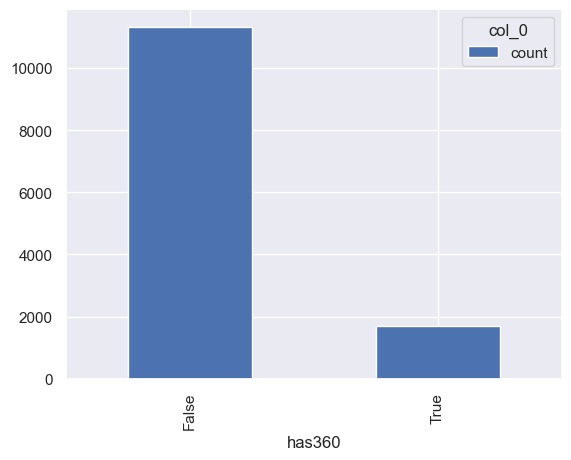

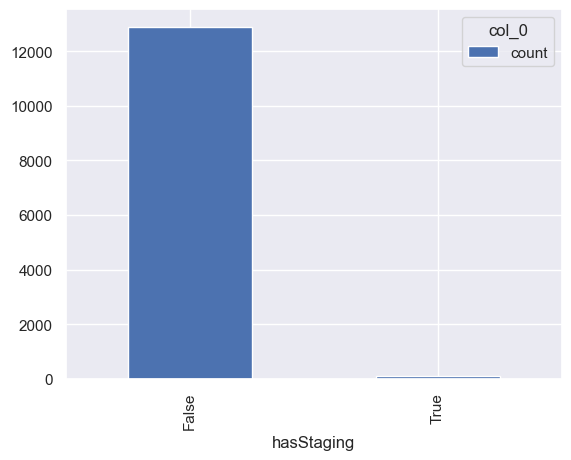

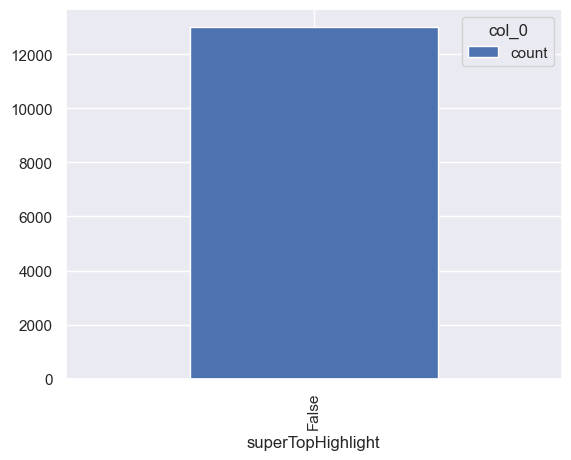

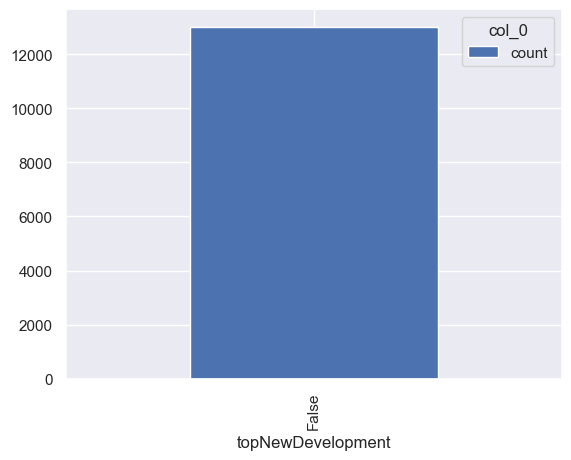

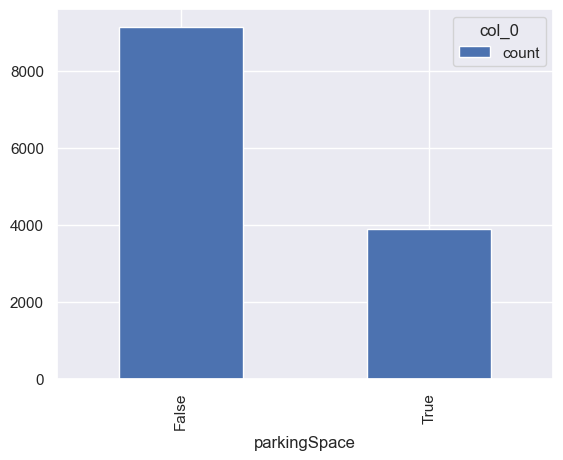

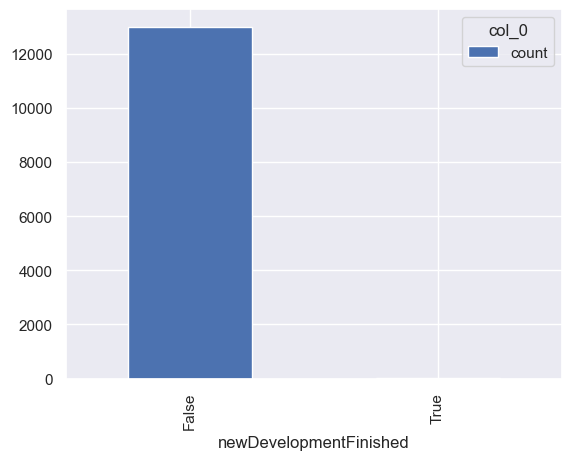

In [25]:
df_categorical = df.select_dtypes(include = ['O','bool'])
for element in df_categorical.columns:
    my_table = pd.crosstab(index = df_categorical[element], columns="count")
    my_table.plot.bar()

In [26]:
# tras este estudio, vemos dos variables categóricas que se nos habían pasado en columnas que no aportan información y procedemos a eliminarlas

print(df.superTopHighlight.value_counts())
print(df.topNewDevelopment.value_counts())

df = df.drop(['superTopHighlight', 'topNewDevelopment'], axis = 1)

df.info()


False    13021
Name: superTopHighlight, dtype: int64
False    13021
Name: topNewDevelopment, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13021 entries, 299 to 21185
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   numPhotos               13021 non-null  int32  
 1   floor                   13021 non-null  object 
 2   price                   13021 non-null  int32  
 3   propertyType            13021 non-null  object 
 4   size                    13021 non-null  int32  
 5   exterior                13021 non-null  bool   
 6   rooms                   13021 non-null  int32  
 7   bathrooms               13021 non-null  int32  
 8   province                13021 non-null  object 
 9   latitude                13021 non-null  float64
 10  longitude               13021 non-null  float64
 11  showAddress             13021 non-null  bool   
 12  distance                13021 non-nu



### Comprobación y eliminación de nulos

In [27]:
# en el apartado de formateo de las variables ya eliminamos valores nulos, de manera que no deberían quedar ninguno

df.isnull().any()

numPhotos                 False
floor                     False
price                     False
propertyType              False
size                      False
exterior                  False
rooms                     False
bathrooms                 False
province                  False
latitude                  False
longitude                 False
showAddress               False
distance                  False
hasVideo                  False
status                    False
newDevelopment            False
hasLift                   False
priceByArea               False
hasPlan                   False
has3DTour                 False
has360                    False
hasStaging                False
parkingSpace              False
newDevelopmentFinished    False
dtype: bool



### Comprobación y eliminación de outliers

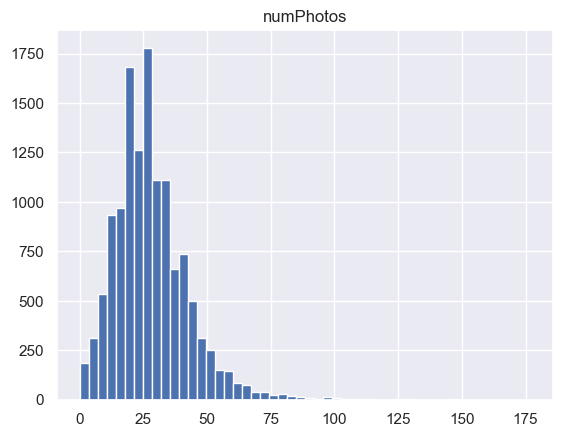

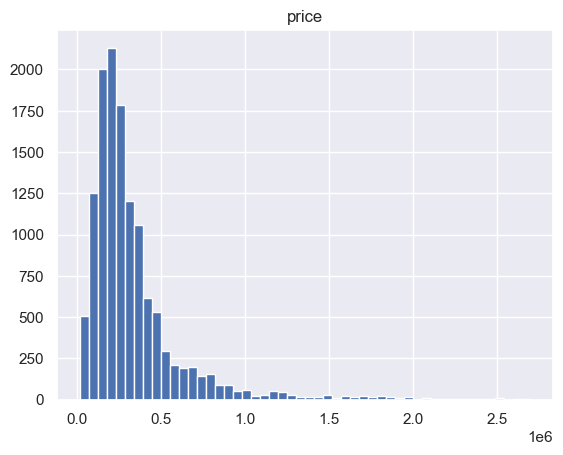

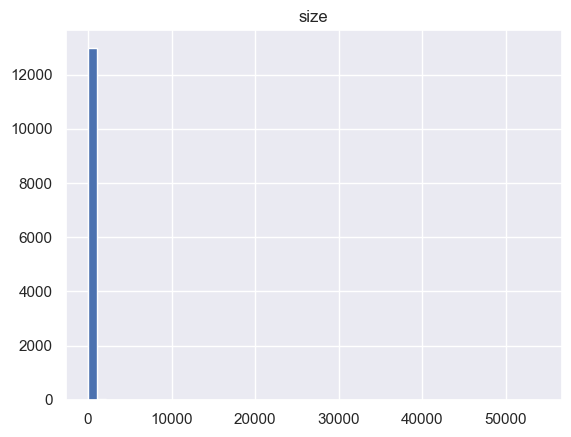

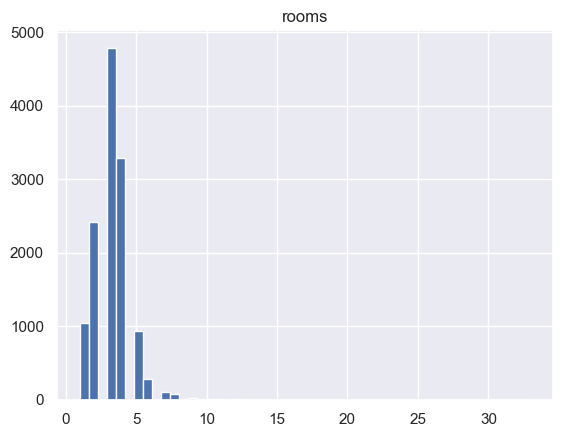

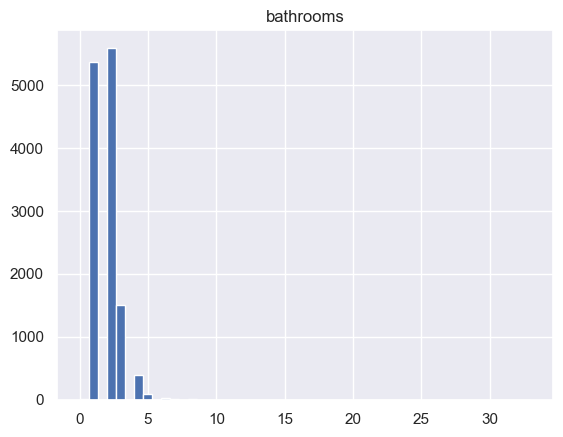

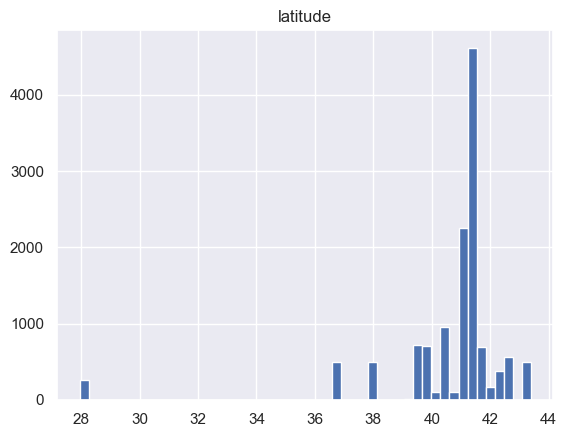

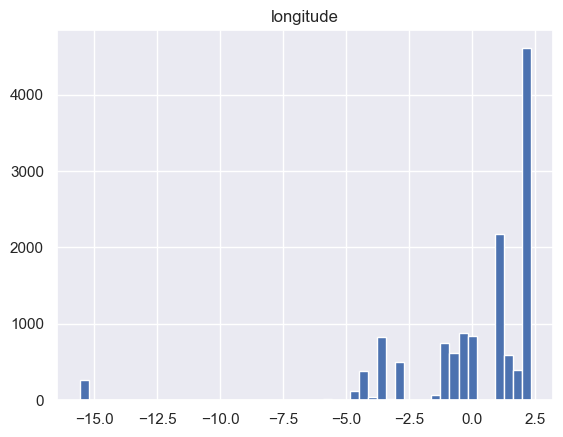

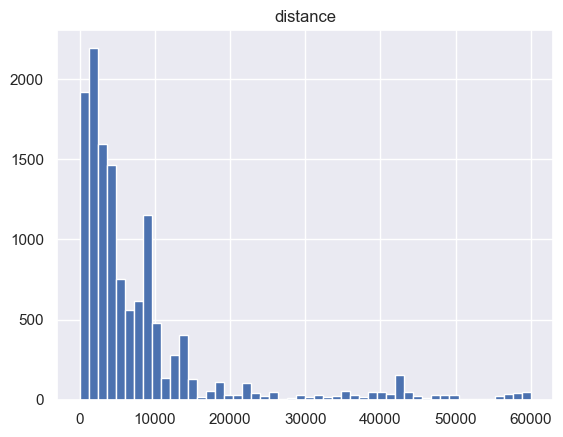

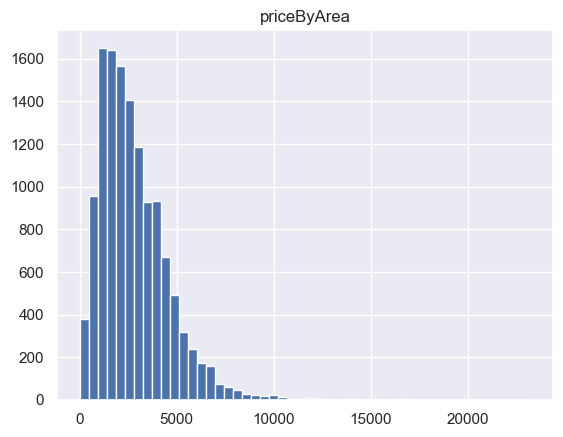

In [28]:
for element in df_numerical.columns:
    df.hist(element,bins=50)

In [29]:
# definimos la función que utilizaremos para calcular los outliers, en este caso he utilizado los percentiles 10 y 90 por la dispersión de muchas de la variables númericas.

def tukey_outliers(df,column,extreme=False):
    q1, q3 = np.percentile(df[column],[15,85])
    iqr = q3 - q1
    constant = 1.5 if not extreme else 3
    return df[((df[column]>(q3+constant*iqr)) | (df[column]<(q1-constant*iqr)))]


In [30]:
# en esta sección iré valorando variable por variable, en 'numPhotos' la verdad es que lo que buscaría es que no haya valores fruto de un error tipográfico.
# un número superior de 100 fotos puede ser posible en una mansión enorme, como es posible que haya propiedades sin foto. Me preocuparía encontrar un valor negativo y un valor superior a 200.
# aun así siendo un número pequeño de outliers y tal y como nos pide el ejercicio los elimino del dataframe

print((df['numPhotos'] < 0).sum())
print((df['numPhotos'] > 200).sum())
df_tukey_numPhotos = tukey_outliers(df,'numPhotos',extreme=False)
print("El número de Outliers es:",df_tukey_numPhotos.shape[0])
df = df.drop(df_tukey_numPhotos.index)
df_tukey_numPhotos = tukey_outliers(df,'numPhotos',extreme=False)
print("El número de Outliers una vez borrados los primeros es:",df_tukey_numPhotos.shape[0])

0
0
El número de Outliers es: 98
El número de Outliers una vez borrados los primeros es: 0


In [31]:
# la columna 'price' como es lógico tiene una horquilla muy amplia porque en el precio de una vivienda existen muchas variables
# para este estudio si tenemos en cuenta que pueda ser utilizado para un cliente medio que no busque ni gangas, ni una mansion la eliminación de outliers nos allanará el camino posteriormente

print((df['price'] < 30000).sum())
print((df['price'] > 1000000).sum())
df_tukey_price = tukey_outliers(df,'price',extreme=False)
print("El número de Outliers es:",df_tukey_price.shape[0])
df = df.drop(df_tukey_price.index)
df_tukey_price = tukey_outliers(df,'price',extreme=False)
print("El número de Outliers una vez borrados los primeros es:",df_tukey_price.shape[0])

81
457
El número de Outliers es: 444
El número de Outliers una vez borrados los primeros es: 105


In [32]:
# basandonos como en la anterior, que el estudio para dirigido a un cliente medio, he decidido en este caso acortar la horquilla para eliminar las viviendas excesivamente grandes

print((df['size'] < 25).sum())
print((df['size'] > 300).sum())
df_tukey_size = tukey_outliers(df,'size',extreme=False)
print("El número de Outliers con percentiles 20/80 es:",df_tukey_size.shape[0])

def tukey_outliers_20(df,column,extreme=False):
    q1, q3 = np.percentile(df[column],[20,80])
    iqr = q3 - q1
    constant = 1.5 if not extreme else 3
    return df[((df[column]>(q3+constant*iqr)) | (df[column]<(q1-constant*iqr)))]

df_tukey_size = tukey_outliers_20(df,'size',extreme=False)
print("El número de Outliers con percentiles 20/80 es:",df_tukey_size.shape[0])
df = df.drop(df_tukey_size.index)
df_tukey_size = tukey_outliers(df,'size',extreme=False)
print("El número de Outliers una vez borrados los primeros es:",df_tukey_size.shape[0])

7
635
El número de Outliers con percentiles 20/80 es: 433
El número de Outliers con percentiles 20/80 es: 727
El número de Outliers una vez borrados los primeros es: 0


In [33]:
# la columna 'rooms' una vez eliminados del dataframe las viviendas muy grandes, nos queda con números mas lógicos.
# podría haber sido interesante haberla convertido a varible categórica para su posterior estudio. 
# Simplemente creando las categorias '1 habitación', '2 habitaciones, '3 habitaciones' y 'mas de 4 habitaciones'

print((df['rooms'] < 1).sum())
print((df['rooms'] > 5).sum())
df_tukey_rooms = tukey_outliers(df,'rooms',extreme=False)
print("El número de Outliers es:",df_tukey_rooms.shape[0])
df = df.drop(df_tukey_rooms.index)
df_tukey_rooms = tukey_outliers(df,'rooms',extreme=False)
print("El número de Outliers una vez borrados los primeros es:",df_tukey_rooms.shape[0])

0
189
El número de Outliers es: 26
El número de Outliers una vez borrados los primeros es: 0


In [34]:
# el ser humano no me deja de sorprender, viviendas con 0 lavabos y otras tantas con mas de 5, teniendo en cuenta que ya habremos descartado las grandes mansiones.
# me he visto moralmente obligado a subir los percentiles de nuevo :)

print((df['bathrooms'] < 1).sum())
print((df['bathrooms'] > 5).sum())
df_tukey_bathrooms = tukey_outliers(df,'bathrooms',extreme=False)
print("El número de Outliers es:",df_tukey_bathrooms.shape[0])

df_tukey_bathrooms = tukey_outliers_20(df,'bathrooms',extreme=False)
print("El número de Outliers con percentiles 20/80 es:",df_tukey_bathrooms.shape[0])
df = df.drop(df_tukey_bathrooms.index)
df_tukey_bathrooms = tukey_outliers(df,'bathrooms',extreme=False)
print("El número de Outliers una vez borrados los primeros es:",df_tukey_bathrooms.shape[0])

10
4
El número de Outliers es: 129
El número de Outliers con percentiles 20/80 es: 129
El número de Outliers una vez borrados los primeros es: 0


In [35]:
# longitud y latitud las voy a analizar juntas porque considero que los outliers outliers que pudieran aparecer pertenecerían a las viviendas de Las Palmas.

df_tukey_latitude = tukey_outliers(df,'latitude',extreme=False)
print("El número de Outliers de latitude es:",df_tukey_bathrooms.shape[0])
df_tukey_longitude = tukey_outliers(df,'longitude',extreme=False)
print("El número de Outliers de longitude es:",df_tukey_bathrooms.shape[0])


El número de Outliers de latitude es: 0
El número de Outliers de longitude es: 0


In [36]:
# otra columna que podríamos haber pasado a variable categorica, simplemente haciendo la categoria 'centro' para distancias inferiores a 1000, 'cercano' a distancias entre 1000 y 5000, y 'periferia' a las superiores.
# no veo la necesidad de borrar viviendas por su distancia al centro, siempre y cuando no fuese ridiculamente alto como para encontrarse fuera de una provincia.

print((df['distance'] < 1).sum())
print((df['distance'] > 50000).sum())
df_tukey_distance = tukey_outliers(df,'distance',extreme=False)
print("El número de Outliers es:",df_tukey_distance.shape[0])
df = df.drop(df_tukey_distance.index)
df_tukey_distance = tukey_outliers(df,'distance',extreme=False)
print("El número de Outliers una vez borrados los primeros es:",df_tukey_distance.shape[0])

0
152
El número de Outliers es: 688
El número de Outliers una vez borrados los primeros es: 136


In [37]:
# llegados a este punto me sorprendería encontrar demasiados outliers ya que hemos filtrado mucho y solo me esperaría encontrar algun error de introducción de datos

print((df['priceByArea'] < 500).sum())
print((df['priceByArea'] > 10000).sum())
df_tukey_priceByArea = tukey_outliers(df,'priceByArea',extreme=False)
print("El número de Outliers es:",df_tukey_priceByArea.shape[0])
df = df.drop(df_tukey_priceByArea.index)
df_tukey_priceByArea = tukey_outliers(df,'priceByArea',extreme=False)
print("El número de Outliers una vez borrados los primeros es:",df_tukey_priceByArea.shape[0])

78
21
El número de Outliers es: 40
El número de Outliers una vez borrados los primeros es: 0




### Comprobar dimensiones y balanceo del dataset (tras terminar limpieza del dataset)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10869 entries, 299 to 21185
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   numPhotos               10869 non-null  int32  
 1   floor                   10869 non-null  object 
 2   price                   10869 non-null  int32  
 3   propertyType            10869 non-null  object 
 4   size                    10869 non-null  int32  
 5   exterior                10869 non-null  bool   
 6   rooms                   10869 non-null  int32  
 7   bathrooms               10869 non-null  int32  
 8   province                10869 non-null  object 
 9   latitude                10869 non-null  float64
 10  longitude               10869 non-null  float64
 11  showAddress             10869 non-null  bool   
 12  distance                10869 non-null  int32  
 13  hasVideo                10869 non-null  bool   
 14  status                  10869 non-nu



## 3. Análisis Exploratorio de Datos (4 puntos)



### Estudio de las variables categóricas

1843.0
3477.0


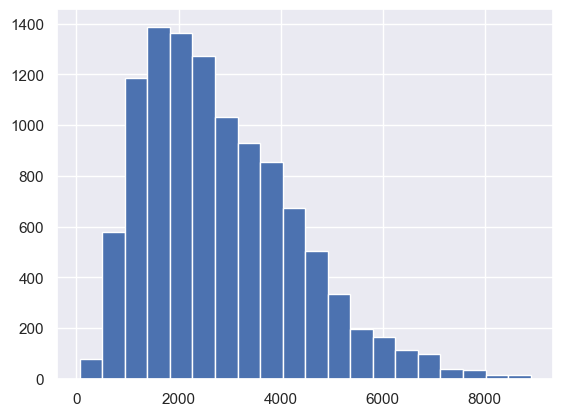

In [39]:
# una vez llegados a este punto me parece interesante crear una variable categórica nueva que haga referencia a si el precio por area es bajo, medio o alto
# para ello primero haremos un pequeño estudio de la variable 'priceByArea'

df['priceByArea'].hist(bins=20)
print(df['priceByArea'].quantile(0.3))
print(df['priceByArea'].quantile(0.7))


In [40]:
# con los datos obtenidos vamos a crear la variable 'priceCategoric' tal que los precios menores a 1800 seran 'barato', los superiores pero inferiores a 3500 serán 'medio' y 3500 o superior 'caro'

def categorize_price(price):
    if price < 1800:
        return 'barato'
    elif price >= 1800 and price < 3500:
        return 'medio'
    else:
        return 'caro'

df['priceCategoric'] = df['priceByArea'].apply(categorize_price)

df.priceCategoric.value_counts()


medio     4512
caro      3240
barato    3117
Name: priceCategoric, dtype: int64

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10869 entries, 299 to 21185
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   numPhotos               10869 non-null  int32  
 1   floor                   10869 non-null  object 
 2   price                   10869 non-null  int32  
 3   propertyType            10869 non-null  object 
 4   size                    10869 non-null  int32  
 5   exterior                10869 non-null  bool   
 6   rooms                   10869 non-null  int32  
 7   bathrooms               10869 non-null  int32  
 8   province                10869 non-null  object 
 9   latitude                10869 non-null  float64
 10  longitude               10869 non-null  float64
 11  showAddress             10869 non-null  bool   
 12  distance                10869 non-null  int32  
 13  hasVideo                10869 non-null  bool   
 14  status                  10869 non-nu

<AxesSubplot:xlabel='parkingSpace'>

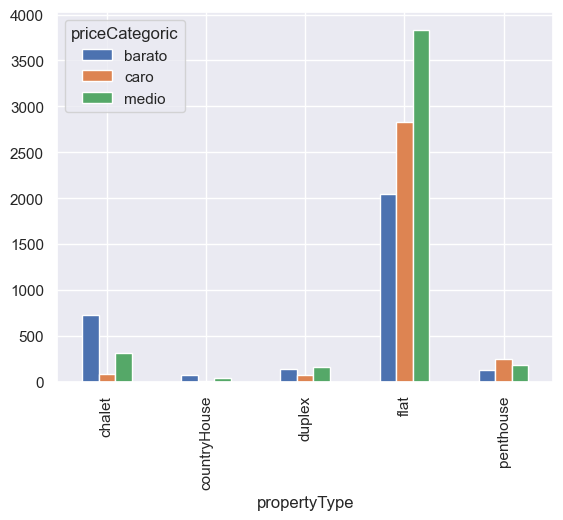

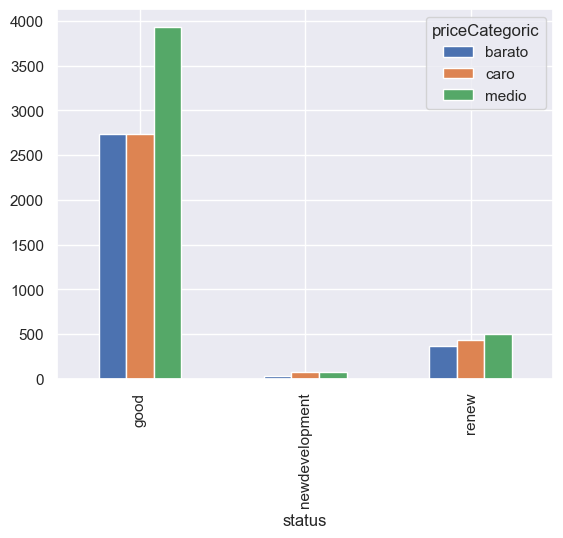

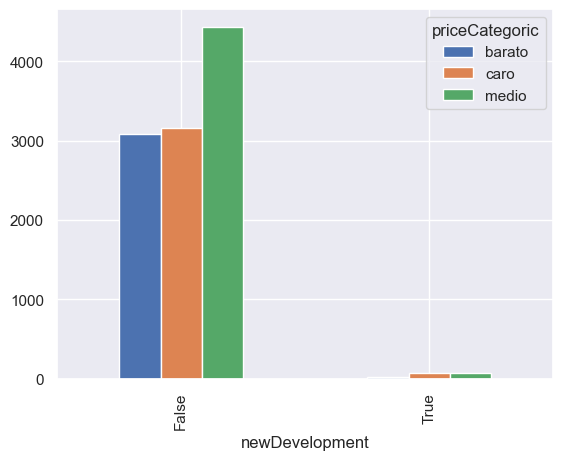

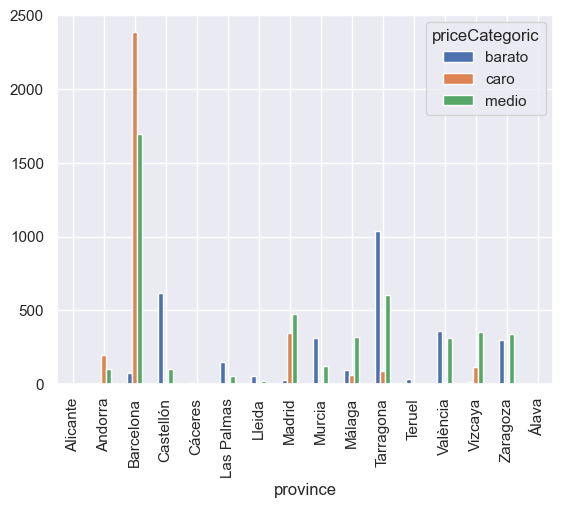

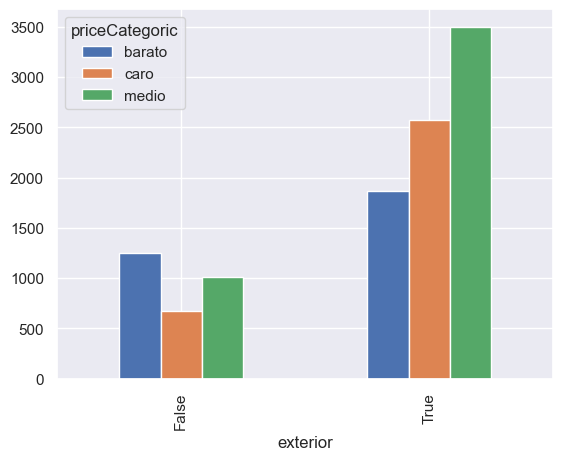

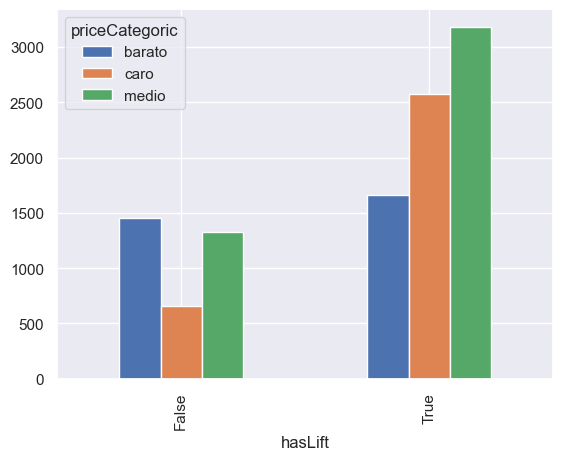

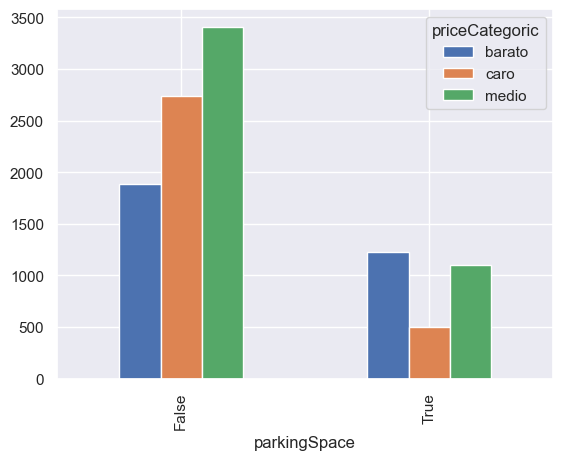

In [42]:
# a partir de ahora utilizaré como variable target a 'priceCategoric' y procedo a hacer estudio de las variables categoricas que considero mas interesantes
# como pudiera ser 'exterior', 'propertyType', 'province', 'status', 'newDevelopment', 'hasLift' y 'parkingSpace'
# otras como 'floor' hemos visto que tomaba muchas variantes, otras como 'hasPlan', 'has3DTour', 'has360', 'hasStaging' y 'superTopHighlight' hacen mas refencia al vendedor que a la vivienda en sí. Pudiendo ser un estudio interesante pero no el que nos lleva ahora.

type_Price = pd.crosstab(index = df['propertyType'], columns=df['priceCategoric'])
type_Price.plot.bar()
status_Price = pd.crosstab(index = df['status'], columns=df['priceCategoric'])
status_Price.plot.bar()
new_Price = pd.crosstab(index = df['newDevelopment'], columns=df['priceCategoric'])
new_Price.plot.bar()
province_Price = pd.crosstab(index = df['province'], columns=df['priceCategoric'])
province_Price.plot.bar()
exterior_Price = pd.crosstab(index = df['exterior'], columns=df['priceCategoric'])
exterior_Price.plot.bar()
lift_Price = pd.crosstab(index = df['hasLift'], columns=df['priceCategoric'])
lift_Price.plot.bar()
parking_Price = pd.crosstab(index = df['parkingSpace'], columns=df['priceCategoric'])
parking_Price.plot.bar()



### Convertir 3 variables categóricas a dummy. Se recomienda utilizar variables que no contengan demasiados posibles valores.

In [43]:
# como la mayoría son booleanas me permito el lujo de convertir 7 variables que no supondrán una gran carga

df_categorical = df[['propertyType', 'exterior', 'status', 'newDevelopment', 'hasLift', 'parkingSpace', 'priceCategoric']]

df_categorical.head()


,propertyType,exterior,status,newDevelopment,hasLift,parkingSpace,priceCategoric
299,flat,True,good,False,True,False,caro
370,flat,True,good,False,True,False,caro
400,flat,False,good,False,True,False,caro
463,flat,True,good,False,False,False,medio
561,duplex,True,good,False,False,False,medio


In [44]:
# a continuación convertimos en dummie cada una de las columnas del dataframe df_categorical

dummy_variables = [col for col in df_categorical.columns]

df_with_dummies = pd.get_dummies(df, columns=dummy_variables)
df_with_dummies.head()


,numPhotos,floor,price,size,rooms,bathrooms,province,latitude,longitude,showAddress,...,status_renew,newDevelopment_False,newDevelopment_True,hasLift_False,hasLift_True,parkingSpace_False,parkingSpace_True,priceCategoric_barato,priceCategoric_caro,priceCategoric_medio
299,23,6,370000,77,3,2,Barcelona,41.379274,2.163821,False,...,0,1,0,0,1,1,0,0,1,0
370,19,9,375000,97,2,2,Barcelona,41.410828,2.201888,True,...,0,1,0,0,1,1,0,0,1,0
400,18,1,684480,118,3,2,Barcelona,41.393423,2.156979,False,...,0,1,0,0,1,1,0,0,1,0
463,33,nan,222000,69,3,1,Barcelona,41.416473,2.206211,False,...,0,1,0,1,0,1,0,0,0,1
561,13,bj,158000,75,1,1,Barcelona,41.381006,2.162536,False,...,0,1,0,1,0,1,0,0,0,1




### Crear variables derivadas en caso que nos parezca interesante incluir alguna

In [45]:
# Este punto lo resolví anteriormente porque me parecía mas interesante para poder hacer el estudio de variables categóricas.



### Cálculo de la matriz de correlación

In [46]:
# creamos la matriz de correlación asegurandonos que los valores que obtenemos seran unicamente positivos

correlation_matrix = df_with_dummies.corr()
correlation_matrix_abs=correlation_matrix.applymap(lambda x: abs(x))



### Pintar la matriz de correlación

<AxesSubplot:>

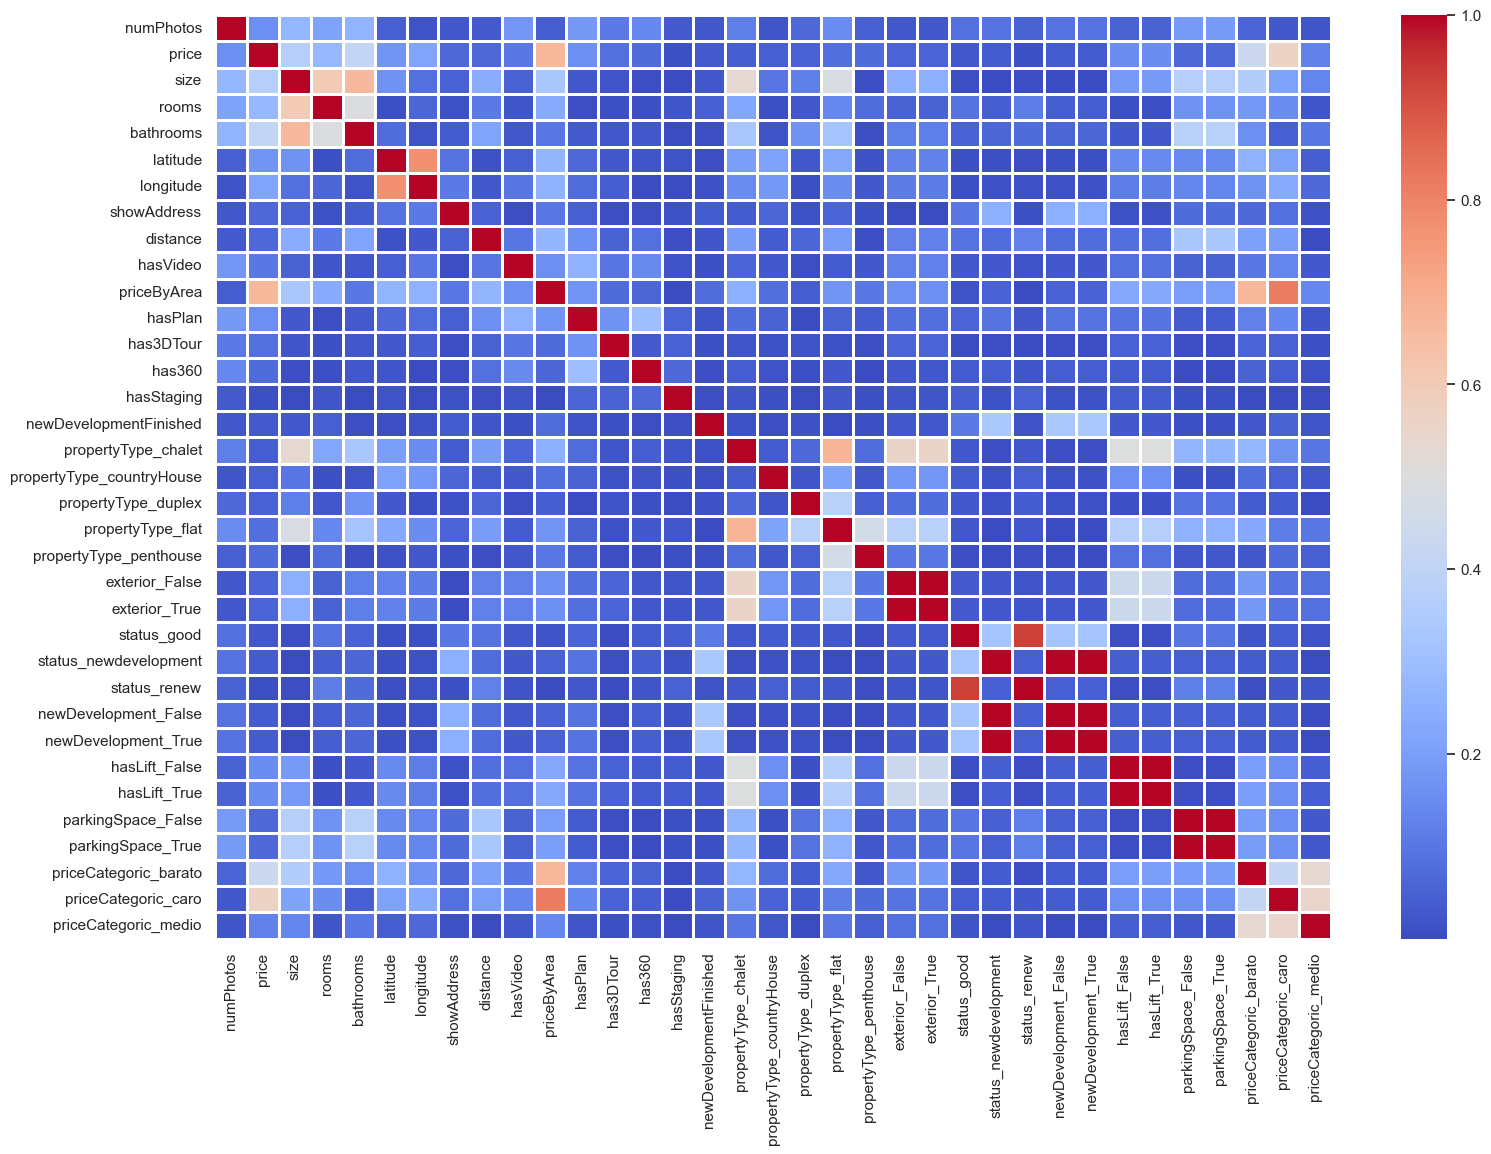

In [47]:
# al pintar la matriz lo siento pero no he encontrado ninguna mejor que coolwarm :(

plt.figure(figsize=(18,12))
sns.heatmap(correlation_matrix_abs, xticklabels=list(correlation_matrix_abs), yticklabels=list(correlation_matrix_abs), fmt='.1f', linewidths = 1, cmap="coolwarm")



### Comprobar si hay variables correlacionadas

In [48]:
# creamos una lista que posteriormente se llenará de pares de variables que tengan una correlación mayor a 0.6, que no coincida fila y columna y que la correlacción sea diferente a 1, para evitar las relaciones entre dummiesde variables booleana en las que cuando una es 'true' la otras será 'false'

lista_corr=[]
for fila in correlation_matrix_abs:
    for columna in correlation_matrix_abs:  
        if (correlation_matrix_abs.loc[fila,columna]>0.6) and (fila!=columna) and correlation_matrix_abs.loc[fila,columna]!=1:
            lista_corr.append([fila,columna,correlation_matrix_abs.loc[fila,columna]])

# hacemos un dataframe a partir de la lista resultante
            
df_corr=pd.DataFrame(lista_corr)

# y a continuación renombramos las columnas, ordenamos los valores de correlación de mayor a menor y reseteamos el indice para que sea ascendente

df_corr.rename(columns={0:'varX',1:'varY',2:'corr'}).sort_values(by='corr',ascending=False).reset_index(drop=True)

,varX,varY,corr
0,parkingSpace_True,parkingSpace_False,1.000000
1,parkingSpace_False,parkingSpace_True,1.000000
2,hasLift_True,hasLift_False,1.000000
3,hasLift_False,hasLift_True,1.000000
4,exterior_False,exterior_True,1.000000
5,exterior_True,exterior_False,1.000000
6,status_renew,status_good,0.930422
7,status_good,status_renew,0.930422
8,priceCategoric_caro,priceByArea,0.814416
9,priceByArea,priceCategoric_caro,0.814416


### **EXTRA**

In [49]:
# visto los resultados tan poco relevantes, he decidido repetir el último apartado pero convirtiendo la columna'province' en dummie

province_with_dummies = pd.get_dummies(df, columns= ['province'])
province_with_dummies.head()

,numPhotos,floor,price,propertyType,size,exterior,rooms,bathrooms,latitude,longitude,...,province_Lleida,province_Madrid,province_Murcia,province_Málaga,province_Tarragona,province_Teruel,province_València,province_Vizcaya,province_Zaragoza,province_Álava
299,23,6,370000,flat,77,True,3,2,41.379274,2.163821,...,0,0,0,0,0,0,0,0,0,0
370,19,9,375000,flat,97,True,2,2,41.410828,2.201888,...,0,0,0,0,0,0,0,0,0,0
400,18,1,684480,flat,118,False,3,2,41.393423,2.156979,...,0,0,0,0,0,0,0,0,0,0
463,33,nan,222000,flat,69,True,3,1,41.416473,2.206211,...,0,0,0,0,0,0,0,0,0,0
561,13,bj,158000,duplex,75,True,1,1,41.381006,2.162536,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# creamos matrix de correlación

correlation_matrix_province = province_with_dummies.corr()
correlation_matrix_province_abs = correlation_matrix_province.applymap(lambda x: abs(x))

<AxesSubplot:>

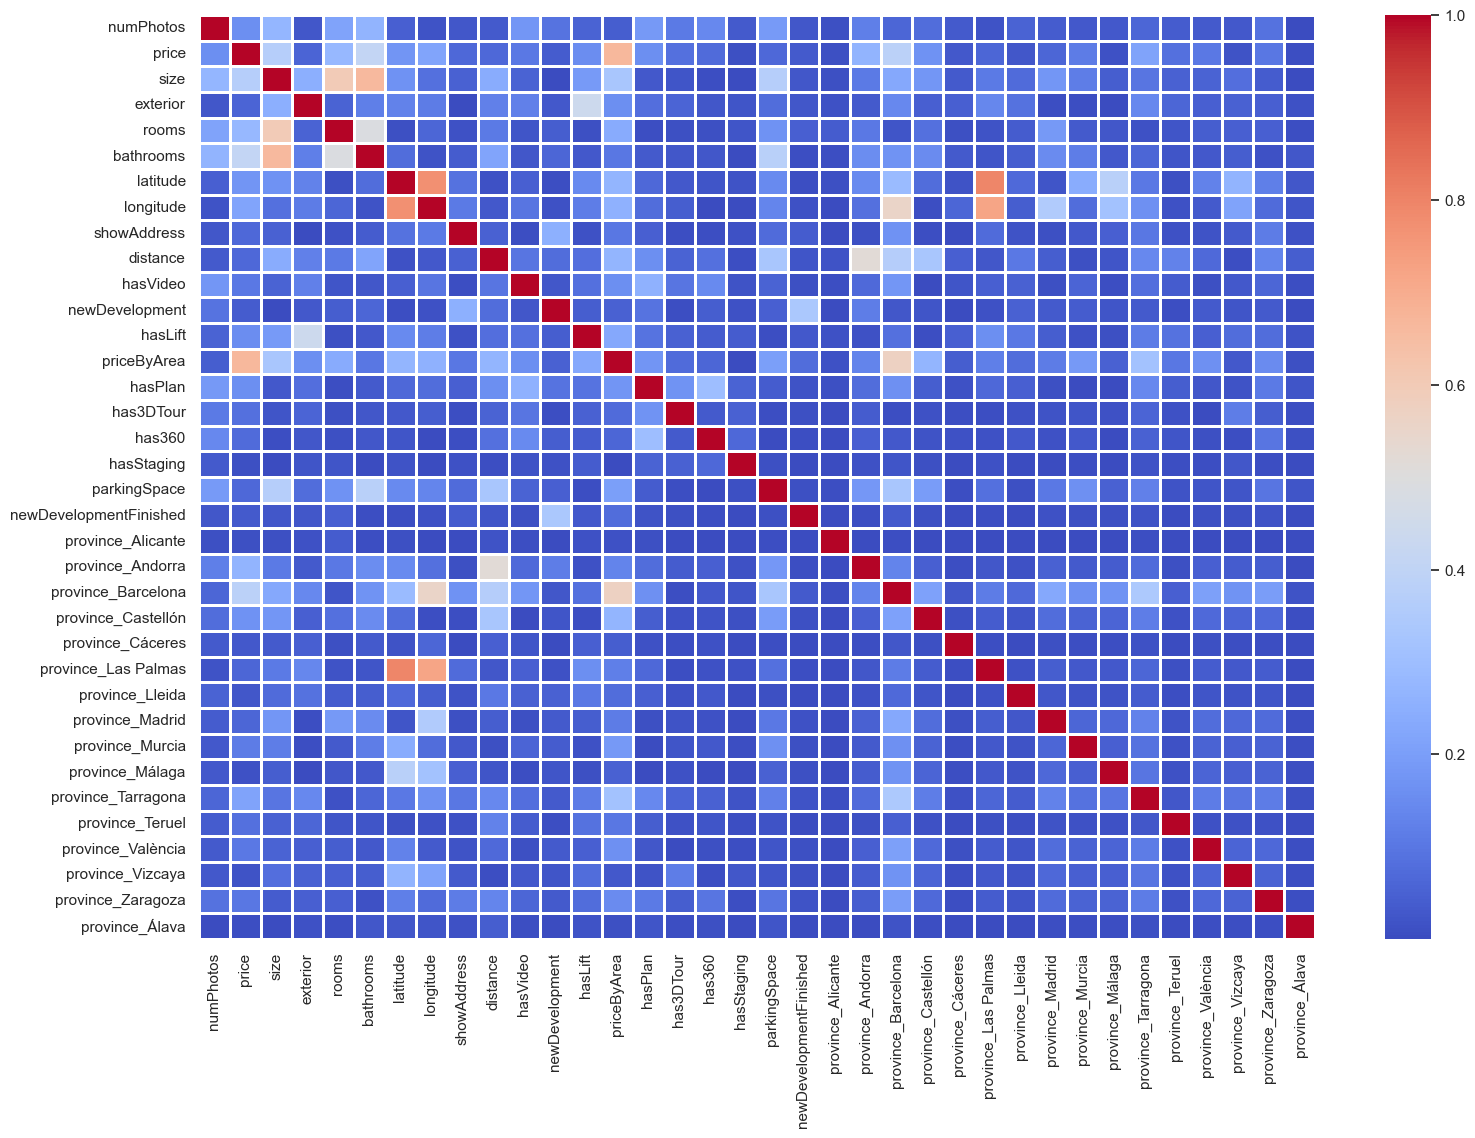

In [51]:
# la dibujamos

plt.figure(figsize=(18,12))
sns.heatmap(correlation_matrix_province_abs, xticklabels=list(correlation_matrix_province_abs), yticklabels=list(correlation_matrix_province_abs), fmt='.1f', linewidths = 1, cmap="coolwarm")

In [52]:
# y por último comprobamos si hay variables correlacionadas
# en este caso he bajado la correlacción a 0.5 para que apareciese la relación entre provincia de Barcelona y Precio por area que me parecía interesante. 

lista_corr_province=[]
for fila in correlation_matrix_province_abs:
    for columna in correlation_matrix_province_abs:  
        if (correlation_matrix_province_abs.loc[fila,columna]>0.5) and (fila!=columna) and correlation_matrix_province_abs.loc[fila,columna]!=1:
            lista_corr_province.append([fila,columna,correlation_matrix_province_abs.loc[fila,columna]])
            
df_corr_province=pd.DataFrame(lista_corr_province)

df_corr_province.rename(columns={0:'varX',1:'varY',2:'corr'}).sort_values(by='corr',ascending=False).reset_index(drop=True)


,varX,varY,corr
0,province_Las Palmas,latitude,0.796352
1,latitude,province_Las Palmas,0.796352
2,latitude,longitude,0.770051
3,longitude,latitude,0.770051
4,longitude,province_Las Palmas,0.718884
5,province_Las Palmas,longitude,0.718884
6,priceByArea,price,0.664291
7,price,priceByArea,0.664291
8,bathrooms,size,0.661182
9,size,bathrooms,0.661182


In [57]:
# he querido hacer un pequeño apendice para prácticar y observar si veiamos alguna correlacción especial para las viviendas de Barcelona. Y sorpresa! en el número uno 'priceByArea', parece que somos unicos poniendo precios!!!

lista_corr_Barcelona=[]
fila = 'province_Barcelona'

for columna in correlation_matrix_province_abs:  
    if (correlation_matrix_province_abs.loc[fila,columna]>0.25) and (fila!=columna):
        lista_corr_Barcelona.append([fila,columna,correlation_matrix_province_abs.loc[fila,columna]])
            
df_corr_Barcelona=pd.DataFrame(lista_corr_Barcelona)

df_corr_Barcelona.rename(columns={0:'varX',1:'varY',2:'corr'}).sort_values(by='corr',ascending=False).reset_index(drop=True)

,varX,varY,corr
0,province_Barcelona,priceByArea,0.571602
1,province_Barcelona,longitude,0.558375
2,province_Barcelona,price,0.384338
3,province_Barcelona,distance,0.363986
4,province_Barcelona,province_Tarragona,0.343227
5,province_Barcelona,parkingSpace,0.330209
6,province_Barcelona,latitude,0.286360
